In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from math import log10 # For metric function

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

https://velog.io/@wilko97/%EB%85%BC%EB%AC%B8%EC%8B%A4%EC%8A%B5-Pix2Pix

In [2]:
# split concatted image into two images
def split_image(image):
    width, height = image.size
    width = int(width / 2)
    left = image.crop((0, 0, width, height))
    right = image.crop((width, 0, width * 2, height))
    return left, right

In [3]:
# Load Dataset from ImageFolder
class Dataset(data.Dataset): # torch기본 Dataset 상속받기
    def __init__(self, image_dir, direction):
        super(Dataset, self).__init__() # 초기화 상속
        self.direction = direction # 
        self.a_path = os.path.join(image_dir, "a") # a는 건물 사진
        self.b_path = os.path.join(image_dir, "b") # b는 Segmentation Mask
        self.image_filenames = [x for x in os.listdir(self.a_path)] # a 폴더에 있는 파일 목록
        self.transform = transforms.Compose([transforms.Resize((256, 256)), # 이미지 크기 조정
                                            transforms.ToTensor(), # Numpy -> Tensor
                                             transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                std=(0.5, 0.5, 0.5)) # Normalization : -1 ~ 1 range
                                            ])
        self.len = len(self.image_filenames)
    
    def __getitem__(self, index):
        
        # 건물사진과 Segmentation mask를 각각 a,b 폴더에서 불러오기
        a = Image.open(os.path.join(self.a_path, self.image_filenames[index])).convert('RGB') # 건물 사진
        b = Image.open(os.path.join(self.b_path, self.image_filenames[index])).convert('RGB') # Segmentation 사진
        
        # 이미지 전처리
        a = self.transform(a)
        b = self.transform(b)
        
        if self.direction == "a2b": # 건물 -> Segmentation
            return a, b
        else:  # Segmentation -> 건물
            return b, a
    
    def __len__(self):
        return self.len
        
train_dataset = Dataset("./data/fonts/train/", "b2a")
test_dataset = Dataset("./data/fonts/test/", "b2a")

train_loader = DataLoader(dataset=train_dataset, num_workers=0, batch_size=1, shuffle=True) # Shuffle
test_loader = DataLoader(dataset=test_dataset, num_workers=0, batch_size=1, shuffle=False)

In [4]:
# -1 ~ 1사이의 값을 0~1사이로 만들어준다
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# 이미지 시각화 함수
def show_images(real_a, real_b, fake_b):
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(real_a.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(132)
    plt.imshow(real_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(fake_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

In [5]:
# Conv -> Batchnorm -> Activate function Layer
'''
코드 단순화를 위한 convolution block 생성을 위한 함수
Encoder에서 사용될 예정
'''
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='relu'):
    layers = []
    
    # Conv layer
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batch Normalization
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
    
    return nn.Sequential(*layers)

# Deconv -> BatchNorm -> Activate function Layer
'''
코드 단순화를 위한 convolution block 생성을 위한 함수
Decoder에서 이미지 복원을 위해 사용될 예정
'''
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.conv1 = conv(3, 64, 4, bn=False, activation='lrelu')  # (B, 64, 128, 128)
        self.conv2 = conv(64, 128, 4, activation='lrelu')  # (B, 128, 64, 64)
        self.conv3 = conv(128, 256, 4, activation='lrelu')  # (B, 256, 32, 32)
        self.conv4 = conv(256, 512, 4, activation='lrelu')  # (B, 512, 16, 16)
        self.conv5 = conv(512, 512, 4, activation='lrelu') # (B, 512, 8, 8)
        self.conv6 = conv(512, 512, 4, activation='lrelu') # (B, 512, 4, 4)

        # Decoder
        self.deconv1 = deconv(512, 512, 4, activation='relu') # (B, 512, 8, 8)
        self.deconv2 = deconv(512 * 2, 512, 4, activation='relu')  # (B, 512, 16, 16) # Skip connection with concatenation or addition
        self.deconv3 = deconv(512 * 2, 256, 4, activation='relu')  # (B, 256, 32, 32)
        self.deconv4 = deconv(256 * 2, 128, 4, activation='relu')  # (B, 128, 64, 64)
        self.deconv5 = deconv(128 * 2, 64, 4, activation='relu')  # (B, 64, 128, 128)
        self.deconv6 = deconv(64 * 2, 3, 4, bn=False, activation='tanh')  # (B, 3, 256, 256)    


    def forward(self, input):
        # Encoder
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        e6 = self.conv6(e5)

        # Decoder
        d1 = F.dropout(self.deconv1(e6), 0.5, training=True)
        d2 = F.dropout(self.deconv2(torch.cat([d1, e5], 1)), 0.5, training=True)
        d3 = F.dropout(self.deconv3(torch.cat([d2, e4], 1)), 0.5, training=True)
        d4 = self.deconv4(torch.cat([d3, e3], 1))
        d5 = self.deconv5(torch.cat([d4, e2], 1))
        output = self.deconv6(torch.cat([d5, e1], 1))

        return output

In [9]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv(6, 64, 4, bn=False, activation='lrelu')
        self.conv2 = conv(64, 128, 4, activation='lrelu')
        self.conv3 = conv(128, 256, 4, activation='lrelu')
        self.conv4 = conv(256, 512, 4, 1, 1, activation='lrelu')
        self.conv5 = conv(512, 1, 4, 1, 1, activation='none')

    # forward method
    def forward(self, input):
        out = self.conv1(input)
        # print(out.shape, "1")
        out = self.conv2(out)
        # print(out.shape, "2")
        out = self.conv3(out)
        # print(out.shape, "3")
        out = self.conv4(out)
        print(out.shape, "4")
        out = self.conv5(out)
        print(out.shape, "5")

        return out

Epoch [1/2], Step[10/12475], d_loss: 1.4946, g_loss: 6.5524


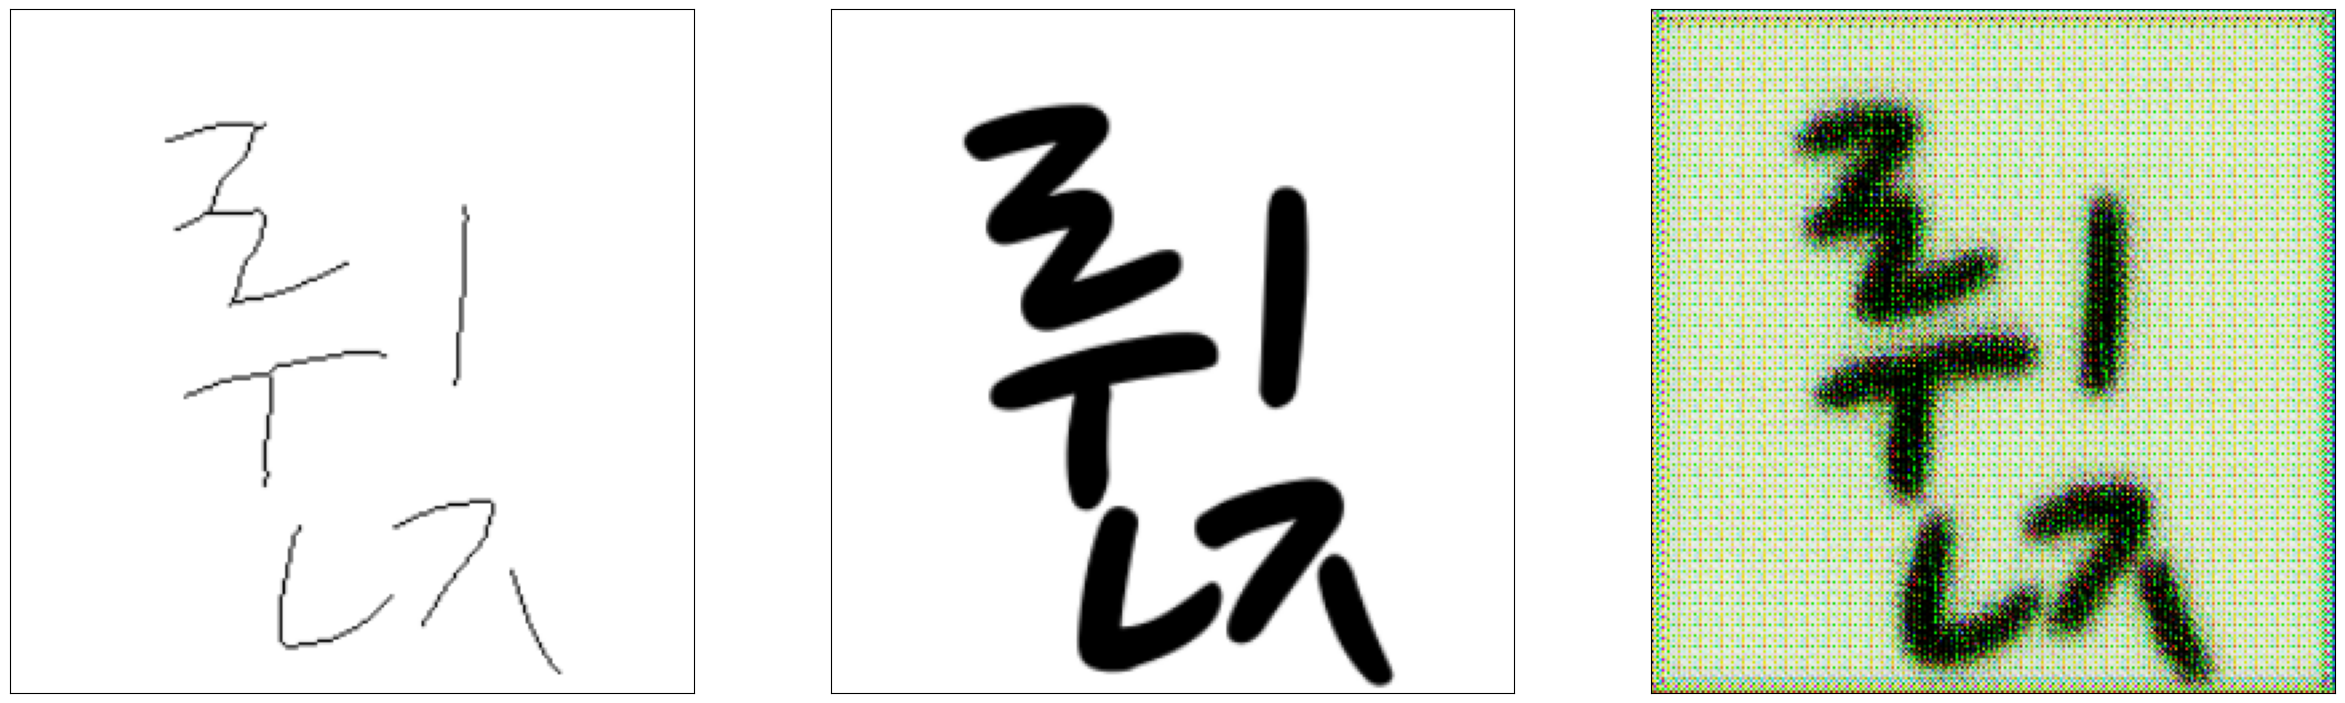

In [10]:
# Generator와 Discriminator를 GPU로 보내기
G = Generator().cuda()
D = Discriminator().cuda()

criterionL1 = nn.L1Loss().cuda()
criterionMSE = nn.MSELoss().cuda()

# Setup optimizer
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

epoch_range = 2
# Train
for epoch in range(1, epoch_range):
    for i, (real_a, real_b) in enumerate(train_loader, 1):
        # forward
        real_a, real_b = real_a.cuda(), real_b.cuda()
        real_label = torch.ones(1).cuda()
        fake_label = torch.zeros(1).cuda()
        
        fake_b = G(real_a) # G가 생성한 fake Segmentation mask
        
        #============= Train the discriminator =============#
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab.detach())
        loss_d_fake = criterionMSE(pred_fake, fake_label)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = D.forward(real_ab)
        loss_d_real = criterionMSE(pred_real, real_label)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        
        # Backprop + Optimize
        D.zero_grad()
        loss_d.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab)
        loss_g_gan = criterionMSE(pred_fake, real_label)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10
        
        loss_g = loss_g_gan + loss_g_l1
        
        # Backprop + Optimize
        G.zero_grad()
        D.zero_grad()
        loss_g.backward()
        g_optimizer.step()
        
        if i % 10 == 0 and i != 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f'
                  % (epoch, epoch_range, i, len(train_loader), loss_d.item(), loss_g.item()))
            print('======================================================================================================')
            show_images(denorm(real_a.squeeze()), denorm(real_b.squeeze()), denorm(fake_b.squeeze()))
            break

In [11]:
torch.save(G.state_dict(), './min_generator.pkl')